# Quantile Transform - Walkthrough

In this notebook, I will be walking through how we can use the Quantile Transform to map our data from X to a marginally Gaussian distributed. I will be modifying the original algorithm with a few extra features that will allow us to handle the boundary issues that can arise.

In [14]:
import os, sys
cwd = os.getcwd()
sys.path.insert(0, f"{cwd}/../")

# Import RBIG Function
import numpy as np
from rbig.data import ToyData
from rbig.quantile import QuantileGaussian
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def plot_2d_joint(data, color='blue'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original Data')
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    plt.show()

<Figure size 360x360 with 0 Axes>

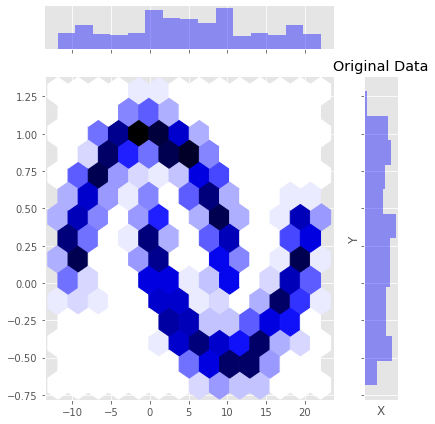

In [201]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'moons'
n_samples = 1_000
noise = 0.1
random_state=123


data = ToyData(dataset, n_samples, noise, random_state).generate_samples()
X = 10* data[:, 0]
Y = data[:, 1]
data[:, 0] = 10 * data[:, 0]

plot_2d_joint(data)

## 1. Get Percentiles

In [212]:
n_quantiles = 500       # precision of our hist dist
subsample   = 500  # we can subsample dist if it's a lot of points

transformer = QuantileGaussian(
    n_quantiles, 
    subsample, 
    random_state,
    domain_ext=.00,
)

transformer.fit(data.copy());

In [213]:
data_G = transformer.transform(data)

Before Interp: -11.866033026860926 22.012572504149432
After Interp: 0.0 1.0
0.0 0.9994122543520776
-inf 3.2447612628792704
Clips: -5.199337582605575 5.19933758270342
-5.199337582605575 3.2447612628792704
Before Interp: -0.6840285460720088 1.2846656306929636
After Interp: 0.0 1.0
0.0 0.9984533664907206
-inf 2.9583141528244257
Clips: -5.199337582605575 5.19933758270342
-5.199337582605575 2.9583141528244257


In [204]:
data_G = transformer.transform(data)

0.0 0.9994122543520776
-inf 3.2447612628792704
Clips: -5.199337582605575 5.19933758270342
-5.199337582605575 3.2447612628792704
0.0 0.9984533664907206
-inf 2.9583141528244257
Clips: -5.199337582605575 5.19933758270342
-5.199337582605575 2.9583141528244257


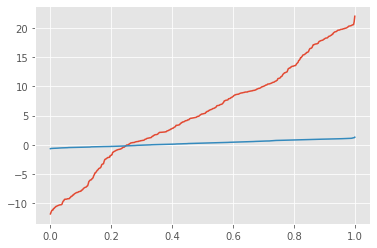

In [205]:
# w/o addition
plt.plot(transformer.references_, transformer.quantiles_)


In [206]:
data.mean(axis=0)

array([4.95504458, 0.2539862 ])

In [207]:

LOWER_BOUNDS_THRESHHOLD = 1e-5
UPPER_BOUNDS_THRESHHOLD = 1e-5
clip_min = stats.norm.ppf(LOWER_BOUNDS_THRESHHOLD - np.spacing(1))
clip_max = stats.norm.ppf(1 - (UPPER_BOUNDS_THRESHHOLD - np.spacing(1)))

print("Clips:", clip_min, clip_max)

Clips: -4.264890793927783 4.2648907939287986


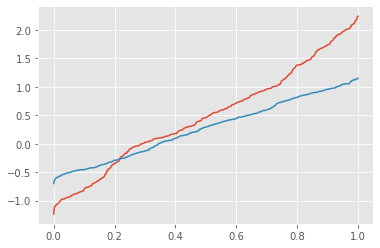

In [199]:
# w/ extension
plt.plot(transformer.references_, transformer.quantiles_)
# plt.plot()

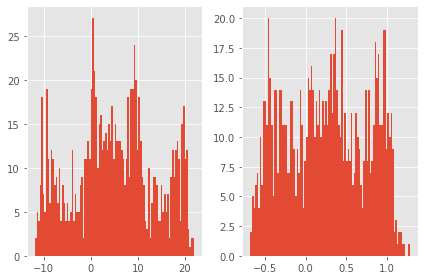

In [208]:
fig, ax = plt.subplots(ncols=2)

ax[0].hist(data[:, 0], bins=100)
ax[1].hist(data[:, 1], bins=100)
plt.tight_layout()
plt.show()

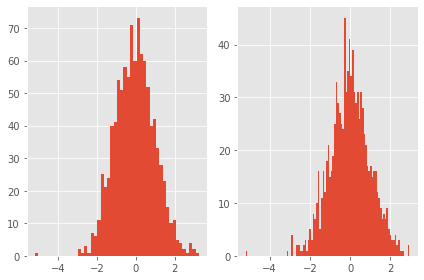

In [209]:
fig, ax = plt.subplots(ncols=2)

ax[0].hist(data_G[:, 0], bins=50)
ax[1].hist(data_G[:, 1], bins=100)
plt.tight_layout()
plt.show()

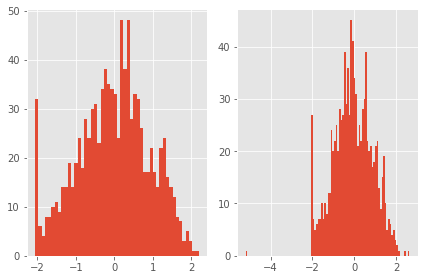

In [135]:
fig, ax = plt.subplots(ncols=2)

ax[0].hist(data_G[:, 0], bins=50)
ax[1].hist(data_G[:, 1], bins=100)
plt.tight_layout()
plt.show()

In [53]:
data_ori = transformer.inverse_transform(data_G)

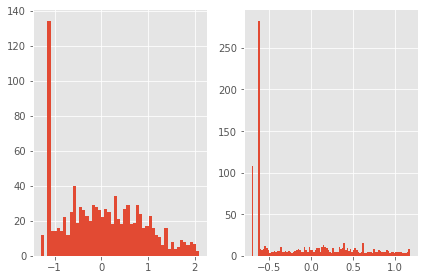

In [54]:
fig, ax = plt.subplots(ncols=2)

ax[0].hist(data_ori[:, 0], bins=50)
ax[1].hist(data_ori[:, 1], bins=100)
plt.tight_layout()
plt.show()

#### TODO:

Figure out a good way to refit the.

**Option I**:

Reorder to space such that we have more bins

* `np.linspace(support_ext, support_ext + 1, href.shape[0])`

**Option II**:

Just have extra bins

* `np.hstack([support_ext, href, support_ext + 1])`

**Option III**:

Be smart and have some sort of distribution...


In [12]:
from scipy.interpolate import interp1d

support_ext = .05
href_ext = np.hstack([support_ext, href, support_ext + 1])

print(href.shape, hpdf.shape, href_ext.shape)
hpdf_new = interp1d(href, hpdf, kind='linear', fill_value='extrapolate', axis=0)(href_ext)

(1000,) (1000, 2) (1002,)


In [13]:
hpdf_new.min(axis=0), hpdf_new.max(axis=0)

(array([-1.25390742, -0.74685278]), array([4.87280296, 4.46753697]))

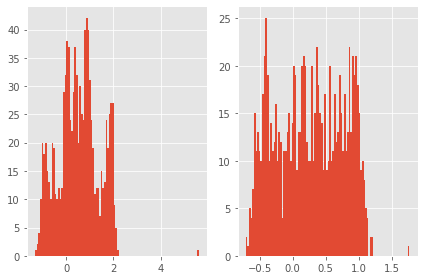

In [180]:
fig, ax = plt.subplots(ncols=2)

ax[0].hist(hpdf_new[:, 0], bins=100)
ax[1].hist(hpdf_new[:, 1], bins=100)
plt.tight_layout()
plt.show()

#### Domain Extension

In [117]:
def extend_support(data, extension=0.1):
    
    # TODO: check that extension is a percentage
    
    # TODO: check input array is 2D
    
    # loop through features
    for idata in data.T:
        
        # get domain support for each feature
        support = np.array([idata.min(), idata.max()])
        
        # get domain extension
        support_ext = extension * np.abs(support[1] - support[0])
        
        # get new support
        support_new = np.array([idata.min() - support_ext, idata.max() + support_ext])
        
    
    return None

In [118]:
new_support = extend_support(data, extension=0.1)

In [116]:
# get domain support for each feature
a, b = hpdf.min(axis=0), hpdf.max(axis=0)
print(a, b)

[-1.32422628 -0.71044844] [2.21641194 1.21781709]


In [110]:
# get the new bounds to add/subtract for the support
support_ext = 0.1
a_ext, b_ext = ( support_ext / 100 ) * np.abs(b - a)
print(a_ext, b_ext)


0.003540638221284704 0.0019282655299678


In [111]:
a_new, b_new = (1 + support_ext) * (a_ext, b_ext)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
support_ext = 

In [ ]:
pdf_ext = 0.1


In [75]:
transformer.quantiles_[:,0].max()

2.216411939869481

In [76]:
transformer.quantiles_[:,0].min(), transformer.quantiles_[:,0].max()

(-1.3242262814152228, 2.216411939869481)

#### Histogram

In [58]:
n_bins = 1_000 #, int(np.ceil(np.sqrt(X.shape[0])))

hpdf = []
hbins = []

for ifeature in data.T:
    counts, edges = np.histogram(ifeature, bins=n_bins, normed=True)
    hpdf.append(counts)
    hbins.append(edges)
    
hpdf = np.transpose(hpdf)
hbins = np.transpose(hbins)

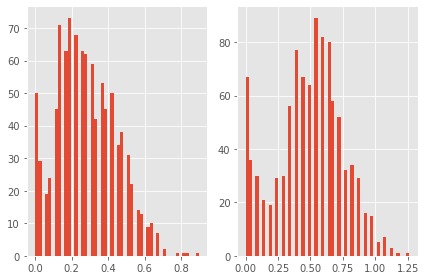

In [60]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(hpdf[:, 0], bins=50)
ax[1].hist(hpdf[:, 1], bins=50)
plt.tight_layout()
plt.show()